In [1]:
%cd ..

/home/akajal/DiVAE


In [2]:
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD

[19:51:37.628] INFO   DiVAE                                             Willkommen!
[19:51:37.629] INFO   DiVAE                                             Loading configuration.


In [5]:
def sample_energies(rbm, rbm_vis, rbm_hid):
    """
    Compute the energies of samples produced by the RBM

    Returns:
        rbm_energy_exp : -vis^T W hid - a^T hid - b^T vis
    """
    # Broadcast W to (pcd_batchSize * nVis * nHid)
    w, vbias, hbias = rbm.weights, rbm.visible_bias, rbm.hidden_bias
    w = w + torch.zeros((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)
    vbias = vbias.to(rbm_vis.device)
    hbias = hbias.to(rbm_hid.device)

    # Prepare H, V for torch.matmul()
    # Change V.size() from (batchSize * nVis) to (batchSize * 1 * nVis)
    vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
    # Change H.size() from (batchSize * nHid) to (batchSize * nHid * 1)
    hid = rbm_hid.unsqueeze(2)

    batch_energies = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1) 
                      - torch.matmul(rbm_vis, vbias)
                      - torch.matmul(rbm_hid, hbias))

    return batch_energies

In [6]:
def plot_sample_energies(energies):
    """
    Plot the energies of the samples produced by the histograms        
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    ax.hist(energies, bins=100)
    
    ax.set_xlabel("Energy", fontsize=60)
    ax.set_ylabel("Frequency", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    plt.show()
    plt.close()

In [7]:
_NUM_NODES = 10

In [8]:
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
rbm = RBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)

In [13]:
crbm_weights = crbm.weights.flatten()
crbm_weights = crbm_weights[crbm_weights.nonzero()]
print(crbm_weights)

tensor([[-1.3853],
        [-1.4366],
        [-0.4853],
        [-1.2124],
        [-1.8716],
        [ 0.3679],
        [ 0.6975],
        [-0.4367],
        [ 0.9556],
        [-1.6782],
        [-0.7251],
        [-0.1146],
        [-1.4363],
        [ 0.4144],
        [-0.4423],
        [-0.3836],
        [-0.7853],
        [ 0.1696],
        [-0.4284],
        [ 0.4531],
        [ 0.2759],
        [-1.6806],
        [ 0.4116],
        [ 0.8946],
        [-1.3253],
        [ 0.5102],
        [-0.1137],
        [-1.6136],
        [ 0.0252],
        [-0.4179],
        [ 0.7971],
        [-0.7915],
        [-0.6527],
        [-1.4217],
        [ 0.9877],
        [ 0.7973],
        [-1.3915],
        [ 0.4833],
        [ 0.6608],
        [-0.8780],
        [-1.4984],
        [-0.1636]], grad_fn=<IndexBackward0>)


In [9]:
crbm_sampler = PCD(batch_size=1024*10, RBM=crbm, n_gibbs_sampling_steps=100)
rbm_sampler = PCD(batch_size=1024*10, RBM=rbm, n_gibbs_sampling_steps=100)

In [10]:
crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()
rbm_vis, rbm_hid = rbm_sampler.block_gibbs_sampling()

In [11]:
crbm_sample_energies = sample_energies(crbm, crbm_vis, crbm_hid).detach().cpu().numpy()
rbm_sample_energies = sample_energies(rbm, rbm_vis, rbm_hid).detach().cpu().numpy()

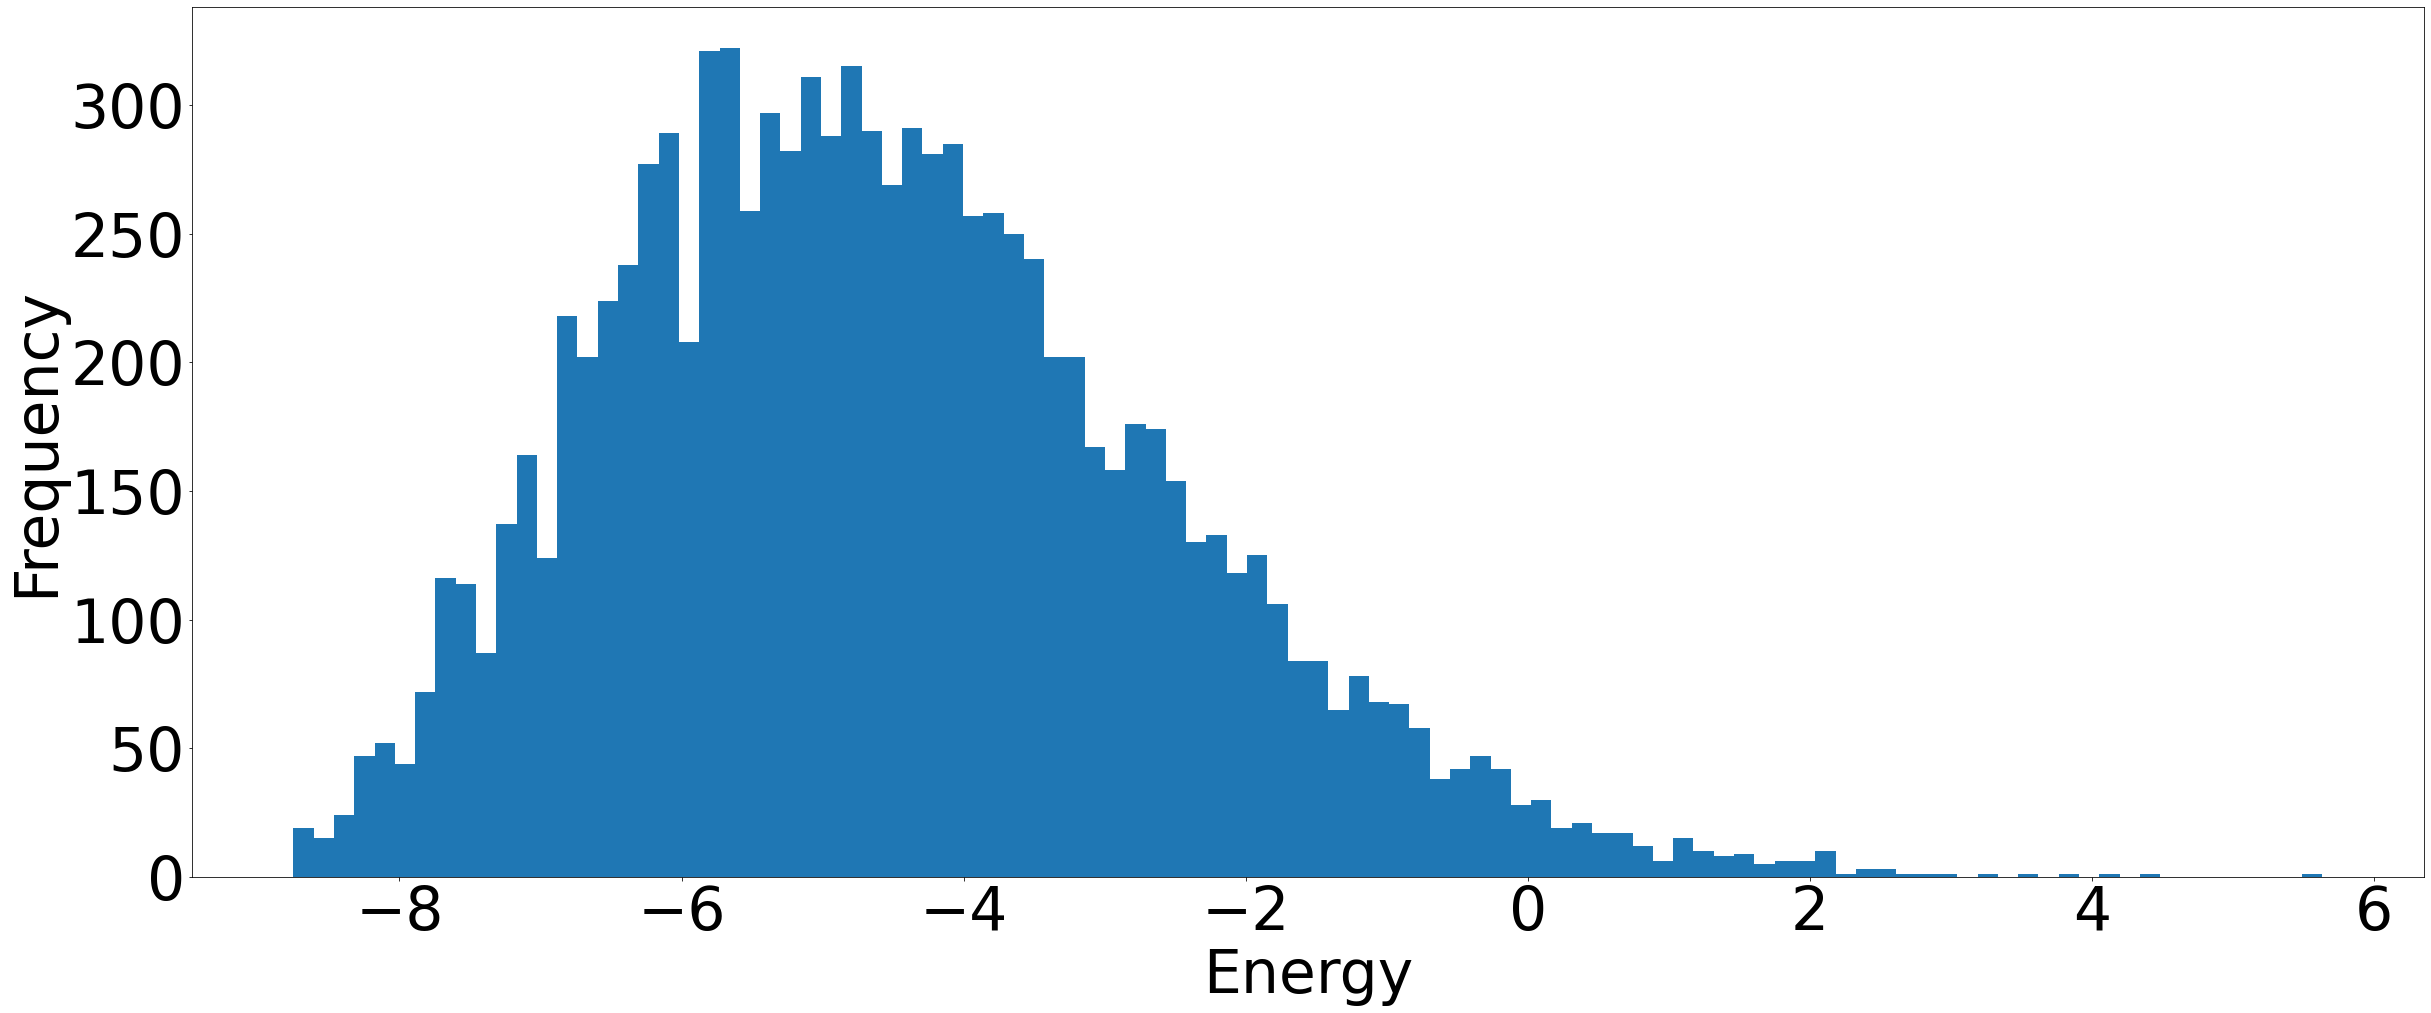

In [12]:
plot_sample_energies(crbm_sample_energies)

In [ ]:
plot_sample_energies(rbm_sample_energies)